# 1. Environment Setup

Imports grouped and loading of environment variables.

In [1]:
import concurrent.futures
import math
import sys
import time
from datetime import date, datetime
from pathlib import Path
import shutil

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder

import autosklearn.classification
import autosklearn.metrics

PROJECT_ROOT = Path.cwd().resolve().parent
if str(PROJECT_ROOT) not in sys.path:
    sys.path.insert(0, str(PROJECT_ROOT))

from src.metrics import collect_performance_over_time, evaluate_metrics


/home/joao/miniconda3/envs/tcc-env/lib/python3.9/site-packages/sklearn/utils/fixes.py:28: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import parse_version  # type: ignore


# 2. Data Loading and Preprocessing

Loads the dataset (defined by variable), splits into train and test, and prepares temporary directories.

In [2]:
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy import sparse as sp
import pandas as pd

def preprocess_text_data(X_train, X_test, text_cols=None):
    """
    Transforms ALL text columns into TF-IDF vectors and concatenates them (with numeric columns passed through).
    If text_cols=None, automatically detects text columns.
    Returns: X_train_vec, X_test_vec, info (dict with vectorizers, text_cols, numeric_cols).
    """

    # 1) detect text columns if not passed
    if text_cols is None:
        text_cols = []
        for c in X_train.columns:
            s = X_train[c]
            if pd.api.types.is_string_dtype(s) or s.dtype == object:
                text_cols.append(c)
            elif pd.api.types.is_categorical_dtype(s):
                # string categories count as text
                try:
                    if pd.api.types.is_object_dtype(s.cat.categories.dtype) or pd.api.types.is_string_dtype(s.cat.categories.dtype):
                        text_cols.append(c)
                except Exception:
                    pass

    # 2) vectorize each text column and stack
    vects_train = []
    vects_test  = []
    vectorizers = {}
    for col in text_cols:
        vec = TfidfVectorizer(
            strip_accents='unicode',
            lowercase=True,
            stop_words='english',
            token_pattern=r'(?u)\b\w\w+\b',
            ngram_range=(1, 2),
            min_df=5,
            max_df=0.95,
            max_features=4000,
            sublinear_tf=True,
            dtype=np.float32
        )
        
        Xtr_col = vec.fit_transform(X_train[col].astype(str).fillna(''))
        Xte_col = vec.transform(X_test[col].astype(str).fillna(''))
        vects_train.append(Xtr_col)
        vects_test.append(Xte_col)
        vectorizers[col] = vec

    # 3) pass numeric columns (if any)
    numeric_cols = [c for c in X_train.columns if c not in text_cols and pd.api.types.is_numeric_dtype(X_train[c])]
    if numeric_cols:
        Xtr_num = sp.csr_matrix(np.asarray(X_train[numeric_cols].fillna(0.0)))
        Xte_num = sp.csr_matrix(np.asarray(X_test[numeric_cols].fillna(0.0)))
        vects_train.append(Xtr_num)
        vects_test.append(Xte_num)

    # 4) final hstack
    X_train_vec = sp.hstack(vects_train).tocsr()
    X_test_vec  = sp.hstack(vects_test).tocsr()

    info = {"vectorizers": vectorizers, "text_cols": text_cols, "numeric_cols": numeric_cols}
    return X_train_vec, X_test_vec, info

In [3]:
def load_dataset(caminho_treino, caminho_teste, target_column='target'):
    X_train = pd.read_csv(caminho_treino)
    X_test = pd.read_csv(caminho_teste)

    y_train = X_train.pop(target_column)
    y_test = X_test.pop(target_column)

    if 'imdb' in caminho_treino.lower():
        X_train, X_test, info = preprocess_text_data(X_train, X_test)

    # Encode labels if they are categorical
    if y_train.dtype == 'object' or y_test.dtype == 'object':
        le = LabelEncoder()
        y_train = le.fit_transform(y_train)
        y_test = le.transform(y_test)

    print(f"Train path: {caminho_treino}, Test path: {caminho_teste}")
    print(f'Train shape: {X_train.shape}, Test shape: {X_test.shape}')
    print(f"Unique classes in y_test: {np.unique(y_test)}")
    
    return X_train, X_test, y_train, y_test

# 3. AutoSklearn Configuration and Execution

Utility functions to run AutoSklearn with or without ensemble and collect essential process information.

In [ ]:
def run_autosklearn(with_ensemble: bool, tmp_dir: Path, X_train, y_train, random_state: int, time_limit_sec: int):
    TIME_LIMIT_SEC = time_limit_sec
    METRIC_SK = autosklearn.metrics.f1_weighted
    automl = autosklearn.classification.AutoSklearnClassifier(
        time_left_for_this_task=TIME_LIMIT_SEC,
        per_run_time_limit=int(TIME_LIMIT_SEC / 10),
        tmp_folder=str(tmp_dir),
        seed=random_state,
        metric=METRIC_SK,
        ensemble_kwargs={'ensemble_size': 10 if with_ensemble else 1},
        memory_limit=1024*5,  # 5GB memory 
        delete_tmp_folder_after_terminate=True,
    )
    start = time.time()
    print(f'Starting AutoSklearn (ensemble={with_ensemble})... time limit: {TIME_LIMIT_SEC}s\n')
    automl.fit(X_train, y_train)
    return automl, time.time() - start

def extract_leaderboard(automl):
    lb = automl.leaderboard(detailed=True, ensemble_only=True).sort_values('ensemble_weight', ascending=False)
    return lb.reset_index(drop=True)

def _sanitize_key(k: str) -> str:
    s = str(k)
    s = s.replace('.', '\uFF0E')
    if s.startswith('$'):
        s = '\uFF04' + s[1:]
    return s

def _ints_dict_to_list(d: dict):
    # If keys are 0..N-1, convert to list
    try:
        keys = list(d.keys())
        if all(isinstance(k, int) for k in keys):
            n = max(keys) + 1 if keys else 0
            if set(keys) == set(range(n)):
                out = [None] * n
                for k, v in d.items():
                    out[k] = v
                return out
    except Exception:
        pass
    return None  # keep dict

def _to_primitive(x):
    # BSON compatible values
    if x is None:
        return None
    if isinstance(x, (str, bool, int, float)):
        # handle NaN/Inf that BSON doesn't accept
        if isinstance(x, float) and (math.isnan(x) or math.isinf(x)):
            return None
        return x
    if isinstance(x, (np.bool_,)):
        return bool(x)
    if isinstance(x, (np.integer,)):
        return int(x)
    if isinstance(x, (np.floating,)):
        v = float(x)
        return None if (math.isnan(v) or math.isinf(v)) else v
    if isinstance(x, (datetime, pd.Timestamp, date)):
        return pd.Timestamp(x).to_pydatetime()
    if isinstance(x, (list, tuple, set)):
        return [_to_bson_safe(v) for v in x]
    if isinstance(x, np.ndarray):
        return [_to_bson_safe(v) for v in x.tolist()]
    if isinstance(x, dict):
        # try optimization for sequential integer dict
        as_list = _ints_dict_to_list(x)
        if as_list is not None:
            return [_to_bson_safe(v) for v in as_list]
        # otherwise, keep dict but with safe string keys
        return {_sanitize_key(k): _to_bson_safe(v) for k, v in x.items()}
    # fallback: string
    return str(x)

def _to_bson_safe(x):
    v = _to_primitive(x)
    # If still dict, ensure safe keys
    if isinstance(v, dict):
        return {_sanitize_key(k): _to_bson_safe(v2) for k, v2 in v.items()}
    return v
# --------------------------------

def serialize_models(automl, leaderboard_df):
    models_serialized = []
    for (_, row), (weight, pipeline) in zip(
        leaderboard_df.iterrows(),
        automl.get_models_with_weights()
    ):
        steps_info = {}
        for name, step in pipeline.steps:
            estimator = step.choice if hasattr(step, 'choice') else step
            try:
                raw_params = estimator.get_params(deep=False)
            except AttributeError:
                raw_params = {}
            steps_info[name] = {
                'algorithm': estimator.__class__.__name__,
                'parameters': _to_bson_safe(raw_params),
            }

        models_serialized.append({
            'weight': float(weight),
            'cost':   float(row['cost']),
            'classifier':            _to_bson_safe(steps_info.get('classifier', {})),
            'data_preprocessor':     _to_bson_safe(steps_info.get('data_preprocessor', {})),
            'feature_preprocessor':  _to_bson_safe(steps_info.get('feature_preprocessor', {})),
        })

    return {
        'total_models': len(models_serialized),
        'models':       models_serialized
    }

# 4. Results Saving

Builds the final JSON document.

In [5]:
def build_document(automl, leaderboard_df, with_ensemble: bool, X_test, y_test, dataset_name: str, time_spent: float, data_folder: str):
    metrics_obj = evaluate_metrics(automl, X_test, y_test)
    model_obj = serialize_models(automl, leaderboard_df)
    perf_time = collect_performance_over_time(automl)

    noise = {
        'data': 'all' in data_folder.lower() or 'feature' in data_folder.lower(),
        'label': 'all' in data_folder.lower() or 'label' in data_folder.lower()
    }
    
    return {
        'timeStamp': datetime.now().astimezone().isoformat(),
        'time_spent': time_spent,
        'dataset': dataset_name,
        'automl': 'autosklearn',
        'with_ensemble': with_ensemble,
        'metrics': metrics_obj,
        'model': {
            **model_obj,
            'graphic': {
                'performance_over_time': perf_time,
                'learning_curve': None
            }
        },
        'noise': noise
    }

# Execution

Runs with and without ensemble, builds documents.

In [ ]:
def workflow(with_ens: bool, label: str, tmp_root, X_train, y_train, random_state: int, time_limit_sec: int):
    folder = tmp_root / label
    automl, time_spent = run_autosklearn(with_ens, folder, X_train, y_train, random_state, time_limit_sec)
    return label, {'doc': None,  'automl': automl, 'leaderboard': None, 'time_spent': time_spent}

def run_experiment(tmp_root: Path, X_train, y_train: str, random_state: int, time_limit_sec: int):
    start = time.time()
    RESULTS = {}

    with concurrent.futures.ProcessPoolExecutor(max_workers=2) as pool:
        futures = [
            pool.submit(workflow, True , 'with_ensemble', tmp_root, X_train, y_train, random_state, time_limit_sec),
            pool.submit(workflow, False, 'without_ensemble', tmp_root, X_train, y_train, random_state, time_limit_sec)
        ]
        for fut in concurrent.futures.as_completed(futures):
            label, data = fut.result()
            RESULTS[label] = data

    print(f'Total time: {time.time()-start:.1f}s')
    return RESULTS

In [7]:
def get_results(RESULTS, X_test, y_test, DATASET_NAME, data_folder: str):
    for label, result in RESULTS.items():
        result['leaderboard'] = extract_leaderboard(result['automl'])
        result['doc']    = build_document(result['automl'], result['leaderboard'], label == 'with_ensemble', X_test, y_test, DATASET_NAME, result['time_spent'], data_folder)
    return RESULTS

# Visualizations

In [8]:
def plots(results):# Comparative plot - all curves in a single graph
    plt.figure(figsize=(12, 8))

    colors = ['#1f77b4', '#ff7f0e']  # Different colors for each line
    line_styles = ['-', '--']  # Different line styles
    markers = ['o', 's']  # Different markers

    for idx, (label, item) in enumerate(results.items()):
        perf = item['doc']['model']['graphic']['performance_over_time']
        
        # Convert timestamps to numeric format (seconds since start)
        timestamps = pd.to_datetime(perf['Timestamp'], format='ISO8601')
        time_seconds = (timestamps - timestamps[0]).total_seconds()
        
        # Plot ensemble optimization score
        if 'ensemble_optimization_score' in perf:
            ensemble_scores = np.array(perf['ensemble_optimization_score'])
            valid_mask = ~np.isnan(ensemble_scores)
            
            # Add small vertical offset to separate lines
            offset = idx * 0.001
            
            plt.plot(
                time_seconds[valid_mask], 
                ensemble_scores[valid_mask] + offset, 
                label=f'Ensemble - {label.replace("_", " ").title()}',
                linewidth=2.5,
                marker=markers[idx],
                markersize=6,
                color=colors[idx],
                linestyle=line_styles[idx],
                alpha=0.8,
                markeredgecolor='white',
                markeredgewidth=1
            )

    plt.title('Performance Comparison - AutoSklearn', fontsize=14, fontweight='bold')
    plt.xlabel('Time (s)', fontsize=12)
    plt.ylabel('F1 Weighted Score', fontsize=12)
    plt.legend(fontsize=10, loc='lower right')
    plt.grid(True, alpha=0.3)
    plt.ylim(0.5, 1.2)
    plt.tight_layout()
    plt.show()

In [9]:
DATASET_NAME = 'iris'
DATA_FOLDER = PROJECT_ROOT / 'data' / 'noise' / 'all'
TIME_LIMIT_SEC = 60 * 1 # 5 minutes
RANDOM_STATE = 1

In [10]:
caminho_treino = str(DATA_FOLDER / DATASET_NAME)+ '_train.csv'
caminho_teste  = str(DATA_FOLDER / DATASET_NAME) + '_test.csv'

X_train, X_test, y_train, y_test = load_dataset(caminho_treino, caminho_teste, target_column='target')
tmp_root = PROJECT_ROOT / 'results' / 'tmp' / 'autosklearn' / DATASET_NAME
if tmp_root.exists():
    shutil.rmtree(tmp_root)

Train path: /home/joao/Documentos/AutoML-in-Focus-Comparison-of-Auto-Sklearn-TPOT-and-Vertex-AI-in-Classification-Tasks/data/noise/all/iris_train.csv, Test path: /home/joao/Documentos/AutoML-in-Focus-Comparison-of-Auto-Sklearn-TPOT-and-Vertex-AI-in-Classification-Tasks/data/noise/all/iris_test.csv
Train shape: (112, 4), Test shape: (38, 4)
Unique classes in y_test: [0 1 2]


In [11]:
RESULTS = run_experiment(tmp_root, X_train, y_train, RANDOM_STATE, TIME_LIMIT_SEC)

Starting AutoSklearn (ensemble=True)... time limit: 60s
Starting AutoSklearn (ensemble=False)... time limit: 60s


Starting AutoSklearn (ensemble=False)... time limit: 60s




Total time: 55.3s


In [12]:
RESULTS = get_results(RESULTS, X_test, y_test, DATASET_NAME, str(DATA_FOLDER))

/home/joao/miniconda3/envs/tcc-env/lib/python3.9/site-packages/autosklearn/automl.py:1860: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  pd.merge(
/home/joao/miniconda3/envs/tcc-env/lib/python3.9/site-packages/autosklearn/automl.py:1860: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  pd.merge(


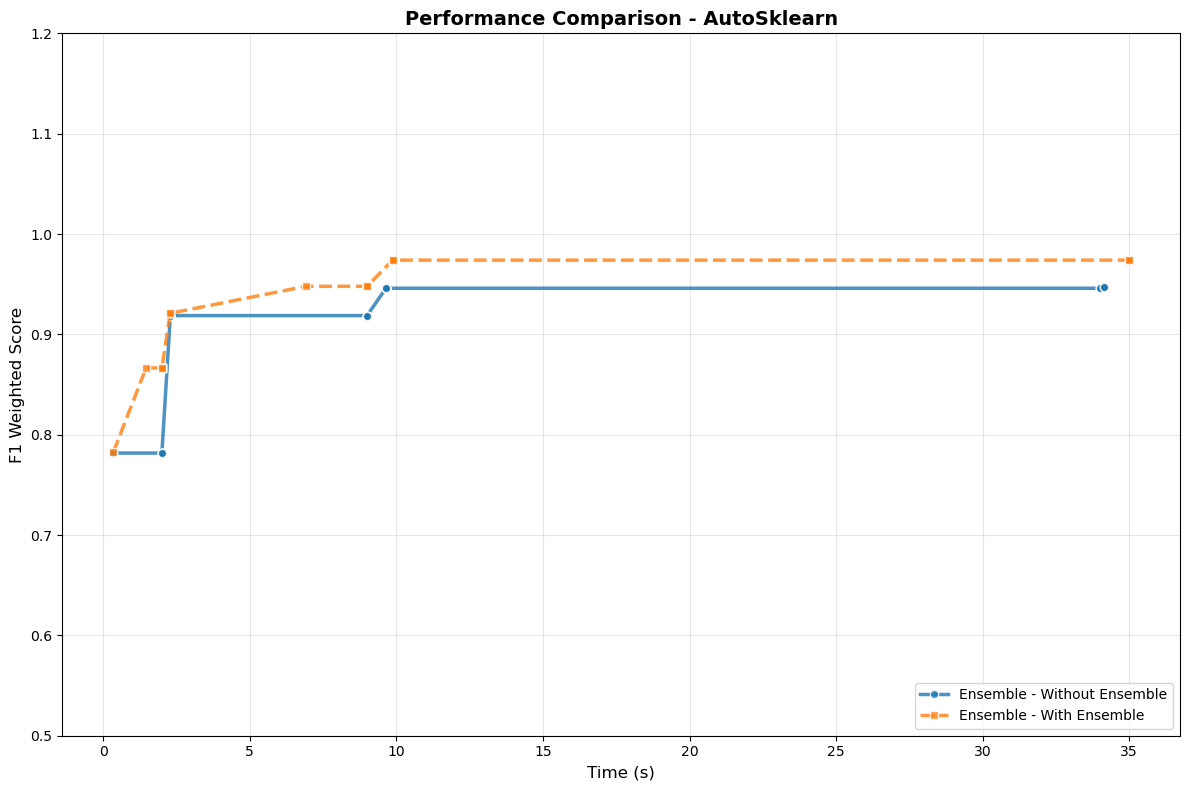

In [13]:
plots(RESULTS)